In [1]:
import pandas as pd
import numpy as np
from data import clean_dataset
import features
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

In [2]:
RAW_DATA_PATH = "../data/raw/olx_house_price_Q122.csv"

In [3]:
df = clean_dataset(RAW_DATA_PATH)

In [4]:
pd.DataFrame({"number": df.isnull().sum(), "percentage":df.isnull().sum().sort_values(ascending=False)/len(df)})

,number,percentage
price,0,0.0
offer_type,0,0.0
floor,0,0.0
area,0,0.0
rooms,0,0.0
offer_type_of_building,0,0.0
market,0,0.0
longitude,0,0.0
latitude,0,0.0
city_name,0,0.0


In [5]:
target = "price"
X = df.drop(target, axis=1)
y = df[target]

preprocessor = features.get_preprocessor(df=X)

X = preprocessor.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.70, random_state=75
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42
)

preprocessor.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__area', 'num__population',
       'ordinal__offer_type', 'ordinal__offer_type_of_building',
       'ordinal__market', 'ordinal__city_name', 'ordinal__voivodeship',
       'remainder__floor', 'remainder__rooms'], dtype=object)

In [6]:
hparam_grid = {
    "n_estimators": np.arange(20, 200, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "log2"],
    "bootstrap": [True],
    "oob_score": [True, False],
}

hparam_grid = {"regressor__" + k: v for k, v in hparam_grid.items()}


In [21]:
reg = RandomForestRegressor(n_jobs=-1, random_state=42)
ttr = TransformedTargetRegressor(regressor=reg, func=np.log, inverse_func=np.exp, check_inverse=False)


opt = RandomizedSearchCV(
    ttr,
    param_distributions=hparam_grid,
    n_iter=50,
    cv=5,
    verbose=True,
    n_jobs = -1
    )

m = opt.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/daniel/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/daniel/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/daniel/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/daniel/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/daniel/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do no

In [19]:
from math import sqrt
import matplotlib.pyplot as plt

def rmse(x,y):
    return sqrt(((x-y)**2).mean())

def print_score(m):
    res = {
        'rmse_train': rmse(m.predict(X_train), y_train), 
        'rmse_valid': rmse(m.predict(X_valid), y_valid),
        'r2_train': m.score(X_train, y_train),
        'r2_valid': m.score(X_valid, y_valid)
    }
    if hasattr(m, 'oob_score_'):
        res['r2_oob'] = m.oob_score_
    print(res)
    
def plot_importances(m, columns):
    importances = m.feature_importances_
    std = np.std([tree.feature_importances_ for tree in m], axis=0)

    forest_importances = pd.Series(importances, index=columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [16]:
# opt.best_estimator_.regressor_.feature_importances_, preprocessor.get_feature_names_out()

{'rmse_train': 104677.97648841566, 'rmse_valid': 145958.5216090216, 'r2_train': 0.7928419579482402, 'r2_valid': 0.6077481151373991}


TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           max_features=0.5,
                                                           min_samples_split=8,
                                                           n_estimators=170,
                                                           n_jobs=-1,
                                                           random_state=42))

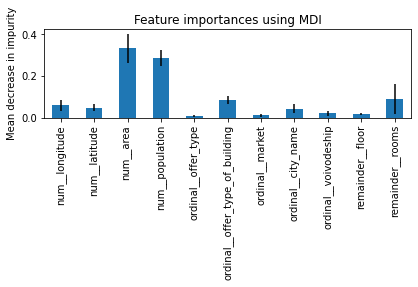

In [20]:
print_score(opt.best_estimator_)
plot_importances(opt.best_estimator_.regressor_, preprocessor.get_feature_names_out())

opt.best_estimator_